In [1]:
import os
import torch
import torch.nn as nn
import evaluate
import numpy as np
from datasets import load_dataset, Audio
from transformers import (
    AutoFeatureExtractor,
    AutoModel,
    TrainingArguments,
    Trainer,
    set_seed
)
NUM_LABEL = 2
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import AutoModel
encoder = AutoModel.from_pretrained("ntu-spml/distilhubert")

from train import DistilHuBERTClassifier, DistilHuBERTClassifierBinary
test_model = "SemanticVAD(256*2_2000).pt"
Semantic_VAD_model = DistilHuBERTClassifier(base_model=encoder, num_labels=NUM_LABEL)
Semantic_VAD_model.load_state_dict(torch.load(test_model, map_location="mps"))
Semantic_VAD_model.eval()

DistilHuBERTClassifier(
  (encoder): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPositionalConvEmbedding(
       


📂 Processing folder: right

📂 Processing folder: really

📂 Processing folder: sure

📂 Processing folder: uh

📂 Processing folder: mm_hm

📂 Processing folder: uh_huh

📂 Processing folder: wow

📂 Processing folder: huh\hum

📂 Processing folder: alright

📂 Processing folder: okay

📂 Processing folder: um

📂 Processing folder: mhm

📂 Processing folder: yeahhh

📂 Processing folder: ah

📂 Processing folder: yeah

📂 Processing folder: eh

📂 Processing folder: oh

📂 Processing folder: hmm

📂 Processing folder: yes

📊 Summary:
📁 right: 13/17 correct (76.47%)
📁 really: 7/15 correct (46.67%)
📁 sure: 14/18 correct (77.78%)
📁 uh: 15/15 correct (100.00%)
📁 mm_hm: 1/17 correct (5.88%)
📁 uh_huh: 16/16 correct (100.00%)
📁 wow: 15/16 correct (93.75%)
📁 huh\hum: 13/13 correct (100.00%)
📁 alright: 16/16 correct (100.00%)
📁 okay: 15/16 correct (93.75%)
📁 um: 16/17 correct (94.12%)
📁 mhm: 15/16 correct (93.75%)
📁 yeahhh: 18/18 correct (100.00%)
📁 ah: 16/16 correct (100.00%)
📁 yeah: 17/17 correct (100.00%)


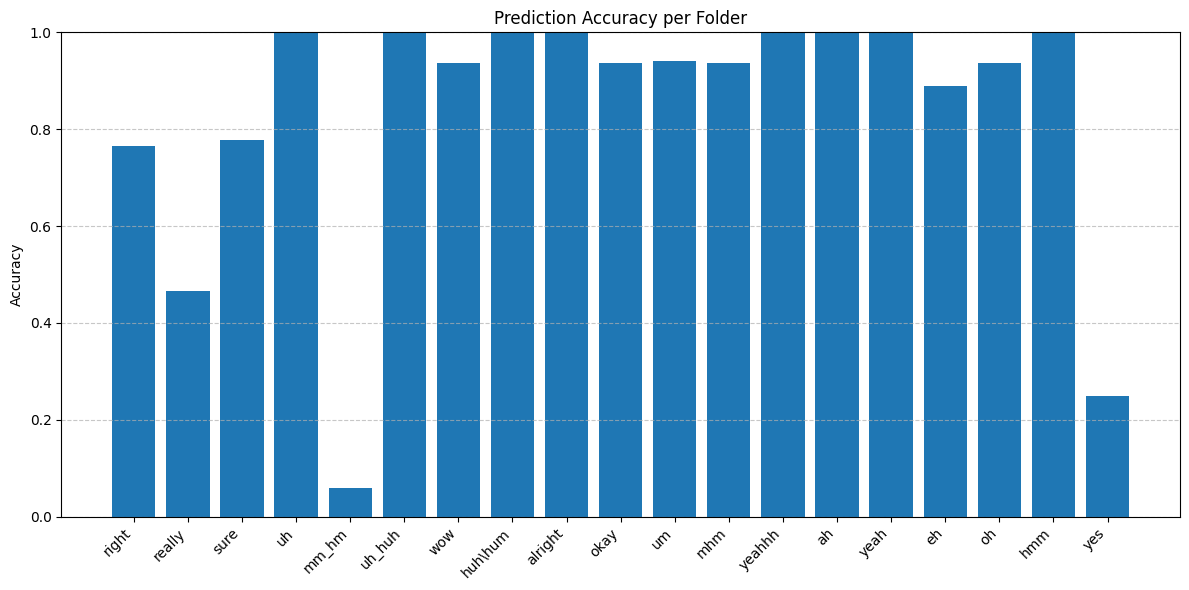

In [2]:
import os
import torchaudio
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoFeatureExtractor

# Step 1: prepare feature_extractor
feature_extractor = AutoFeatureExtractor.from_pretrained("ntu-spml/distilhubert")

# Step 2: model
Semantic_VAD_model.eval()

# Step 3: record statistics
stats = defaultdict(lambda: {"total": 0, "correct": 0})

# Rule: which folder names are considered as backchannel
backchannel_keywords = [
    "ah",
    "alright",
    "eh",
    "hmm",
    "huh",
    "hum",
    "mhm",
    "mm hm",
    "oh",
    "okay",
    "really",
    "right",
    "sure",
    "uh",
    "uh huh",
    "um",
    "wow",
    "yeah",
    "yeahhh"
]

# Step 4: walk through
datasets_root = "./datasets_record_test/testset"

for folder_name in os.listdir(datasets_root):
    folder_path = os.path.join(datasets_root, folder_name)
    if not os.path.isdir(folder_path):
        continue

    print(f"\n📂 Processing folder: {folder_name}")

    is_backchannel_label = any(keyword in folder_name for keyword in backchannel_keywords)

    for file_name in os.listdir(folder_path):
        if not file_name.endswith(".wav"):
            continue

        file_path = os.path.join(folder_path, file_name)
        
        waveform, sr = torchaudio.load(file_path)
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)
            sr = 16000

        inputs = feature_extractor(waveform.squeeze().numpy(), sampling_rate=sr, return_tensors="pt")

        with torch.no_grad():
            outputs = Semantic_VAD_model(**inputs)
            logit = outputs.logits.squeeze()
            probs = torch.sigmoid(logit)
            backchannel_prob = probs[0].item()

        predict_backchannel = backchannel_prob > 0.5

        stats[folder_name]["total"] += 1
        if predict_backchannel == is_backchannel_label:
            stats[folder_name]["correct"] += 1

# Step 5: summary report
print("\n📊 Summary:")
categories = []
accuracies = []

for folder, result in stats.items():
    total = result["total"]
    correct = result["correct"]
    accuracy = correct / total if total > 0 else 0
    print(f"📁 {folder}: {correct}/{total} correct ({accuracy:.2%})")

    categories.append(folder)
    accuracies.append(accuracy)

total_samples = sum(r["total"] for r in stats.values())
total_correct = sum(r["correct"] for r in stats.values())
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
print(f"\n🎯 Overall: {total_correct}/{total_samples} correct ({overall_accuracy:.2%})")

# Step 6: plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Prediction Accuracy per Folder")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()